In [6]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [7]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id source_id experiment_id member_id table_id  \
0  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
1  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
2  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
3  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
4  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   

  variable_id grid_label                                             zstore  \
0          pr         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
1        prsn         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
2         tas         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
3      tasmax         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
4      tasmin         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   

   dcpp_init_year  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [8]:
# clunky way to do this, just doing this for example, these are the 16 models that have all of our variables of interest 
source_ids = ['BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [9]:
def load_tas_data(source_id, expt_id):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

def load_data(source_id, expt_id, var_name):
    """
    Load monthly data for given source and expt ids
    """
    df_var = df[(df.table_id == 'Amon') & (df.variable_id == var_name)
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 1.)),
                     'lon': (['lon'], np.arange(0.5, 360., 1.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [6]:
var_name = 'hus'
#results = {}

first = 1
for source_id in tqdm(source_ids):
    # take 1980-2019 mean
    ds = (load_data(source_id, 'historical', var_name)
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
#    elif ('i' in ds.dims) and ('j' in ds.dims):
#        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens = ds_new
        first = 0
    else:
        ens = xr.concat([ens, ds_new], pd.Index(np.append(ens.ensemble.values, ds_new.attrs['name']), name='ensemble'))

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_80x96_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



In [10]:
def get_ens_members(var_name):

    first = 1
    for source_id in tqdm(source_ids):
        # take 1980-2019 mean
        ds = (load_data(source_id, 'historical', var_name)
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))
    
        # rename spatial dimensions if necessary
        if ('longitude' in ds.dims) and ('latitude' in ds.dims):
            ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
    #    elif ('i' in ds.dims) and ('j' in ds.dims):
    #        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
        # regrid to common 1deg by 1deg grid
        ds_new = regrid_to_common(ds[var_name], ds_out)
        ds_new.attrs['name'] = source_id
    
        # drop redundant variables (like "height: 2m")
        for coord in ds_new.coords:
            if coord not in ['lat','lon']:
                ds_new = ds_new.drop(coord)
    
        # Add ensemble as new dimension
        ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
        # Add run to ensemble DataArray
        if first:
            ens = ds_new
            first = 0
        else:
            ens = xr.concat([ens, ds_new], pd.Index(np.append(ens.ensemble.values, ds_new.attrs['name']), name='ensemble'))
        
    return(ens)

In [11]:
ens_tas = get_ens_members('tas')

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



In [12]:
ens_pr = get_ens_members('pr')
ens_psl = get_ens_members('psl')
ens_uas = get_ens_members('uas')
ens_vas = get_ens_members('vas')
ens_hus = get_ens_members('hus')

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_145x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_145x192_178x360_peri.nc



Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc



### Want to have arrays that are ens x lat x lon for EACH variable 

In [13]:
obs_tas = ens_tas.mean(dim='ensemble').compute()
obs_pr = ens_pr.mean(dim='ensemble').compute()
obs_psl = ens_psl.mean(dim='ensemble').compute()
obs_uas = ens_uas.mean(dim='ensemble').compute()
obs_vas = ens_vas.mean(dim='ensemble').compute()

In [31]:
## Use multi-model mean as temporary stand-in for observations
#obs = ens.mean(dim='ensemble').compute()

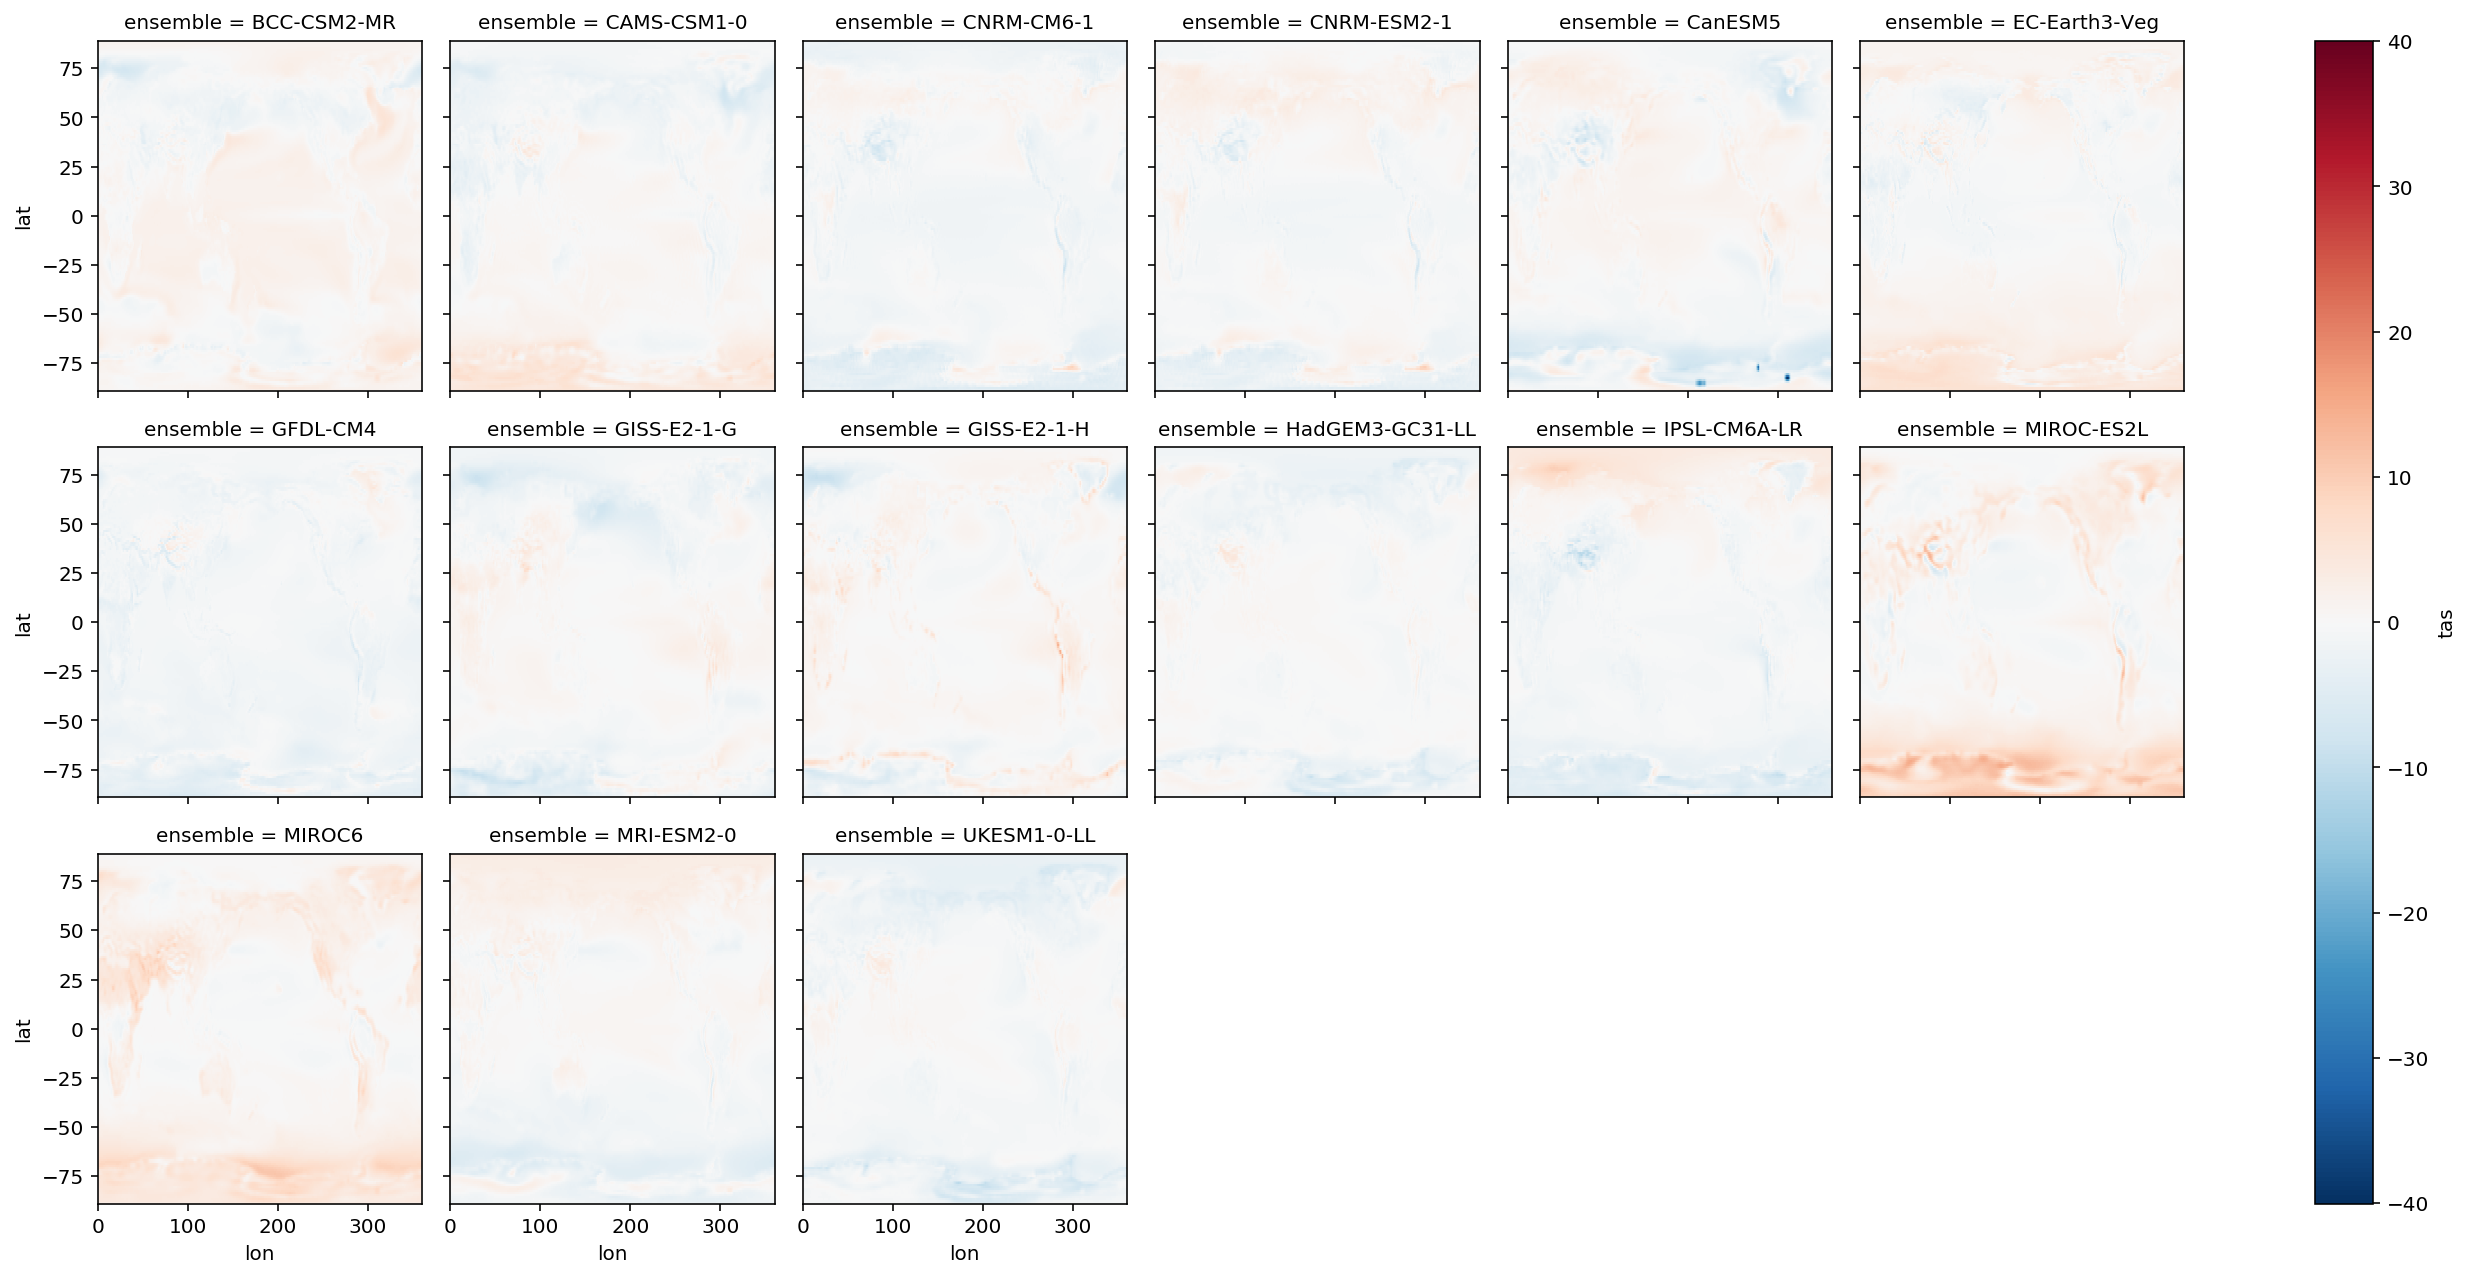

In [26]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_tas = (ens_tas-obs_tas).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

In [27]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_pr = (ens_pr-obs_pr).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

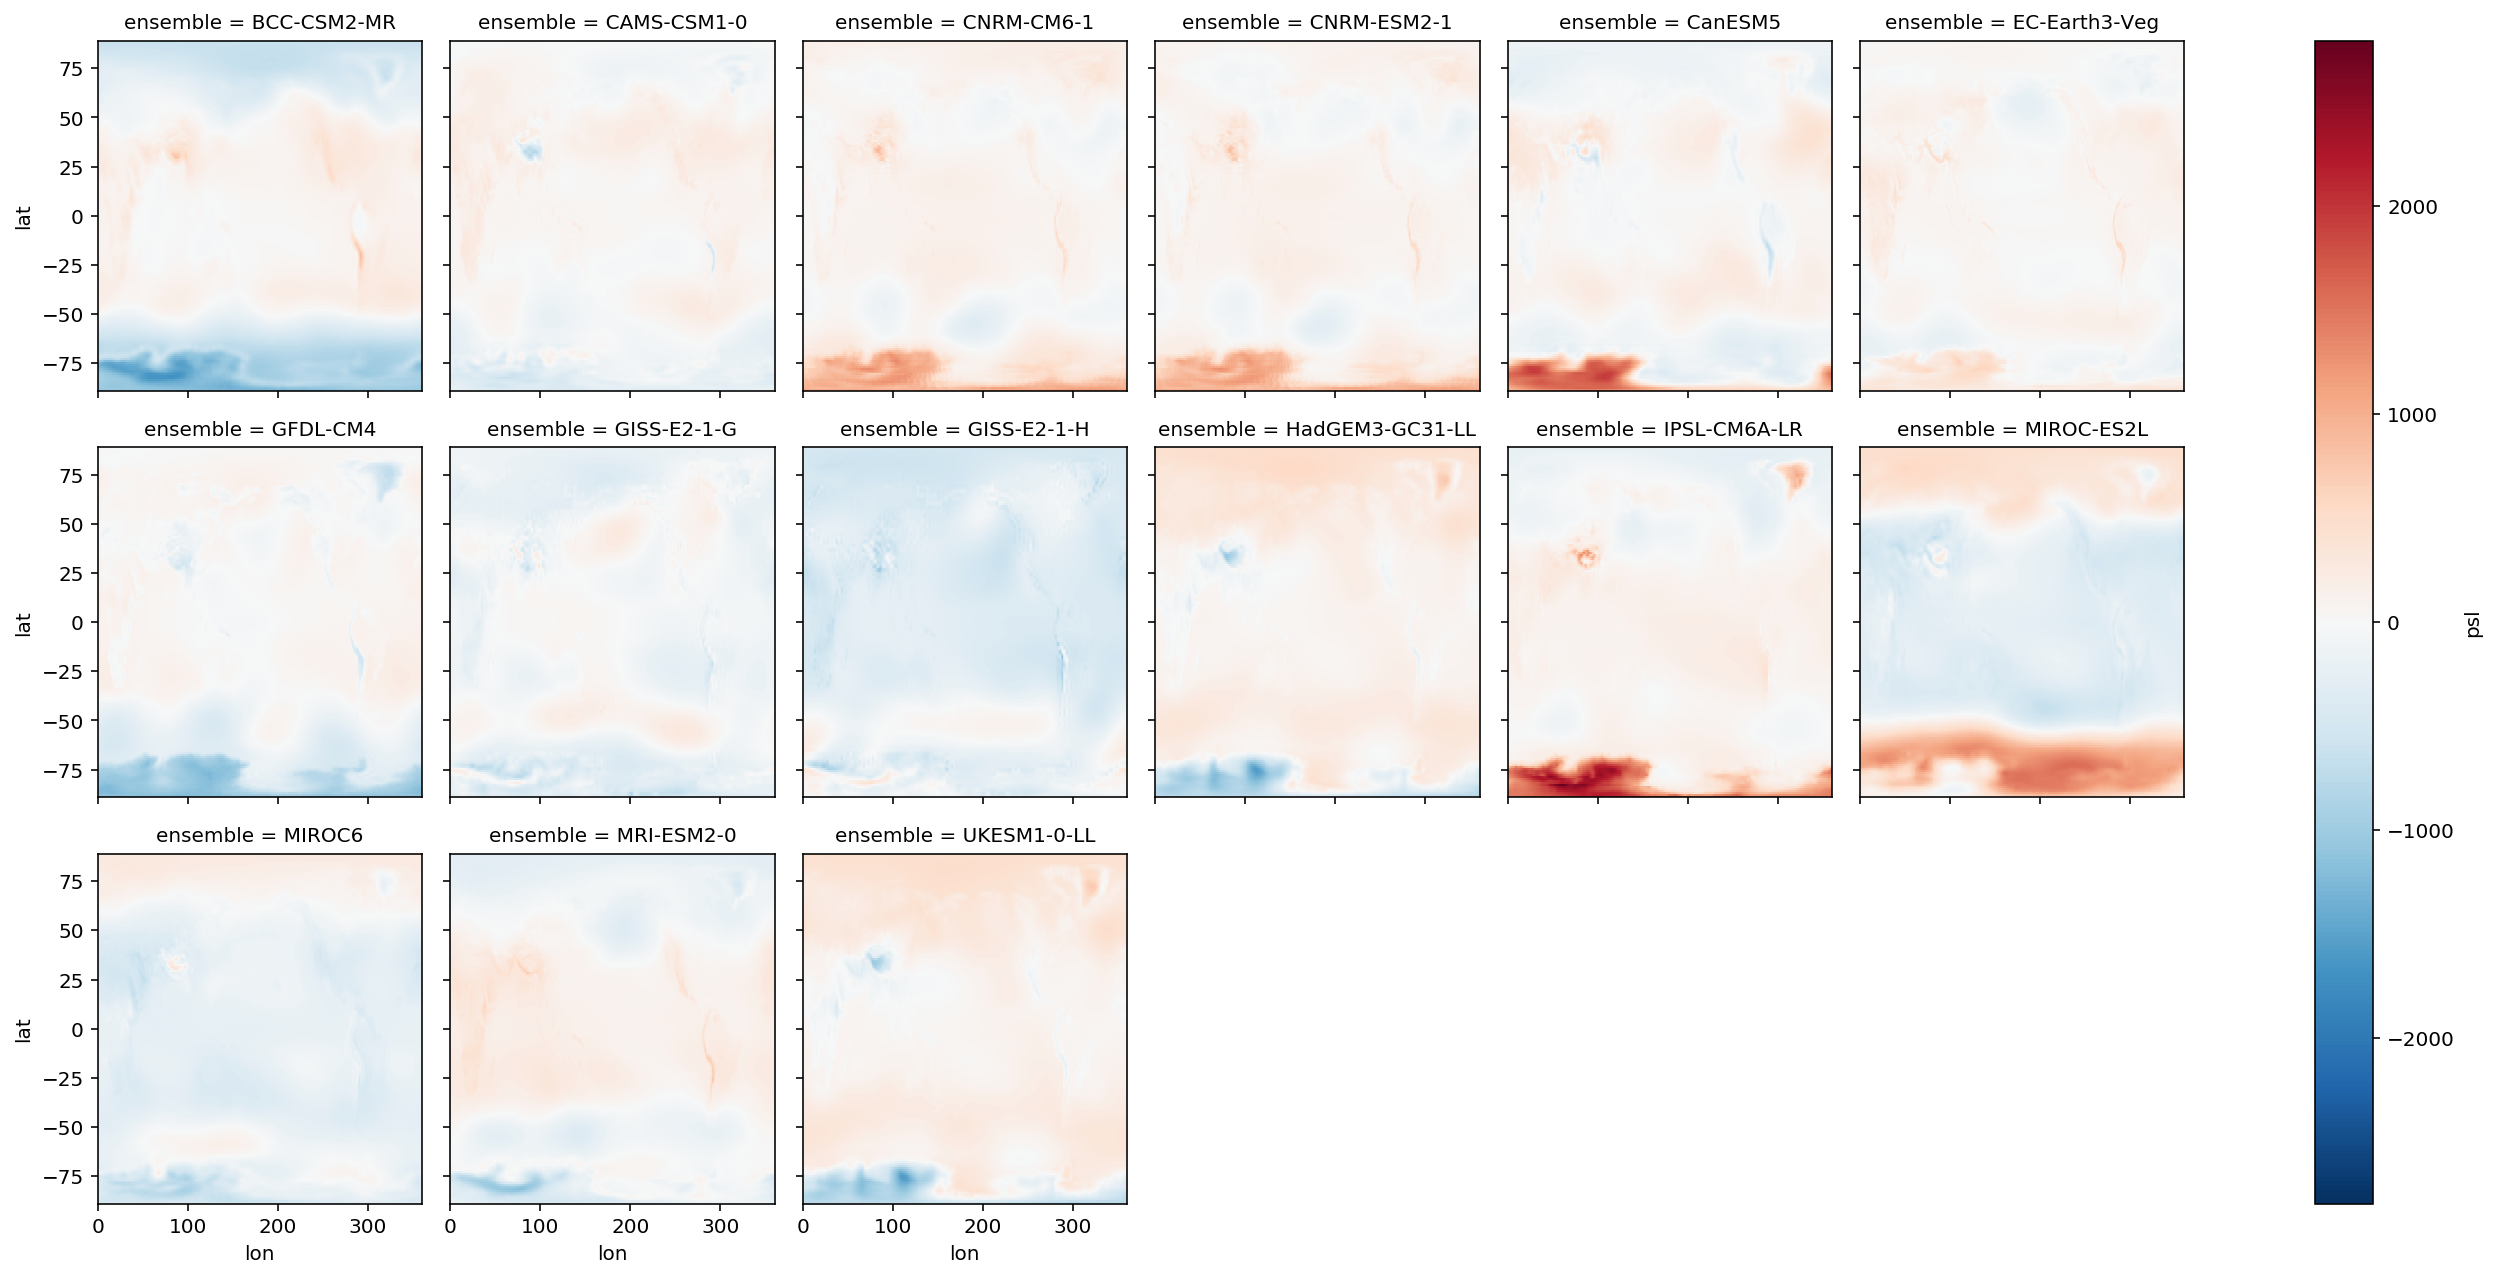

In [28]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_psl = (ens_psl-obs_psl).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

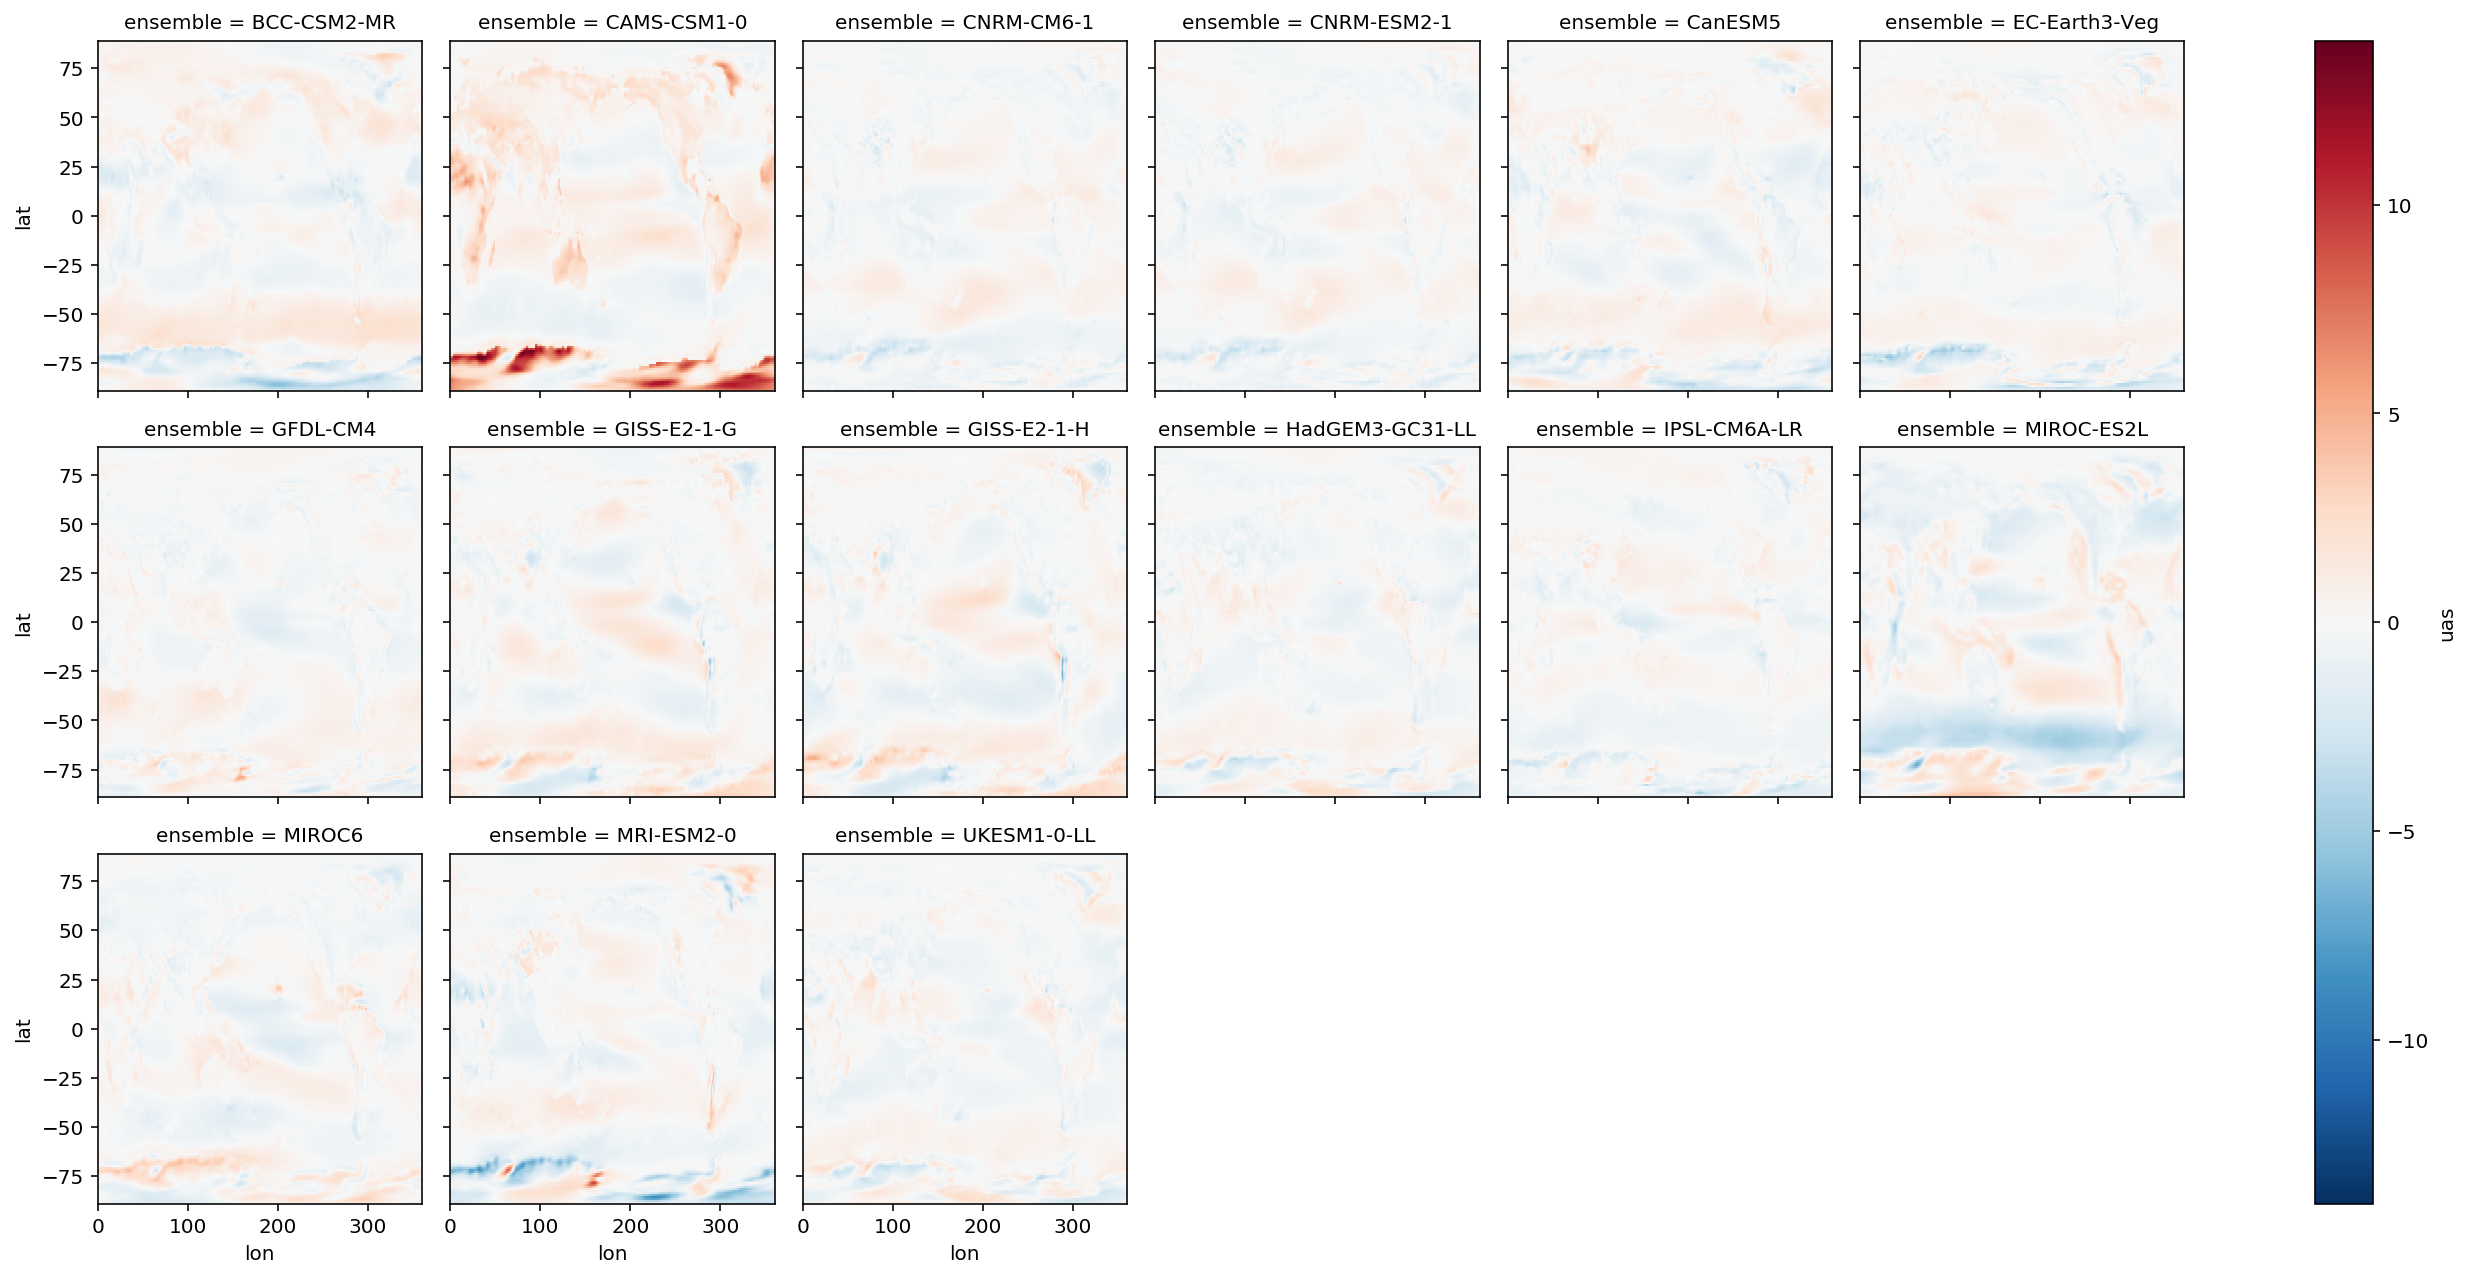

In [29]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_uas = (ens_uas-obs_uas).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

In [30]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_vas = (ens_vas-obs_vas).plot(x='lon', y='lat', col='ensemble', col_wrap=6)



In [14]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens_tas.attrs['rmse'] = {}
ens_tas.attrs['mae'] = {}
for ensemble in ens_tas.ensemble:
    ds = ens_tas.sel(ensemble=ensemble)
    ens_tas.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_tas, ds, ['lat', 'lon']).values
    ens_tas.attrs['mae'][str(ensemble.values)] = xs.mae(obs_tas, ds, ['lat', 'lon']).values
ens_tas.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array(1.63380416),
  'CAMS-CSM1-0': array(1.86142087),
  'CNRM-CM6-1': array(1.69358948),
  'CNRM-ESM2-1': array(1.42370996),
  'CanESM5': array(2.10765918),
  'EC-Earth3-Veg': array(1.97754579),
  'GFDL-CM4': array(1.63110232),
  'GISS-E2-1-G': array(1.79627861),
  'GISS-E2-1-H': array(1.53376457),
  'HadGEM3-GC31-LL': array(1.4029837),
  'IPSL-CM6A-LR': array(2.27349437),
  'MIROC-ES2L': array(3.68173347),
  'MIROC6': array(2.85588393),
  'MRI-ESM2-0': array(1.80691406),
  'UKESM1-0-LL': array(1.87983856)},
 'mae': {'BCC-CSM2-MR': array(1.32501237),
  'CAMS-CSM1-0': array(1.32109091),
  'CNRM-CM6-1': array(1.29015014),
  'CNRM-ESM2-1': array(1.0687295),
  'CanESM5': array(1.42995774),
  'EC-Earth3-Veg': array(1.42108118),
  'GFDL-CM4': array(1.32383009),
  'GISS-E2-1-G': array(1.23167486),
  'GISS-E2-1-H': array(0.98542311),
  'HadGEM3-GC31-LL': array(0.92138995),
  'IPSL-CM6A-LR': array(1.6267579),
  'MIROC-ES2L': array(2.311807

In [15]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens_pr.attrs['rmse'] = {}
ens_pr.attrs['mae'] = {}
for ensemble in ens_pr.ensemble:
    ds = ens_pr.sel(ensemble=ensemble)
    ens_pr.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_pr, ds, ['lat', 'lon']).values
    ens_pr.attrs['mae'][str(ensemble.values)] = xs.mae(obs_pr, ds, ['lat', 'lon']).values
ens_pr.attrs

ens_psl.attrs['rmse'] = {}
ens_psl.attrs['mae'] = {}
for ensemble in ens_psl.ensemble:
    ds = ens_psl.sel(ensemble=ensemble)
    ens_psl.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_psl, ds, ['lat', 'lon']).values
    ens_psl.attrs['mae'][str(ensemble.values)] = xs.mae(obs_psl, ds, ['lat', 'lon']).values
ens_psl.attrs

ens_uas.attrs['rmse'] = {}
ens_uas.attrs['mae'] = {}
for ensemble in ens_uas.ensemble:
    ds = ens_uas.sel(ensemble=ensemble)
    ens_uas.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_uas, ds, ['lat', 'lon']).values
    ens_uas.attrs['mae'][str(ensemble.values)] = xs.mae(obs_uas, ds, ['lat', 'lon']).values
ens_uas.attrs

ens_vas.attrs['rmse'] = {}
ens_vas.attrs['mae'] = {}
for ensemble in ens_vas.ensemble:
    ds = ens_vas.sel(ensemble=ensemble)
    ens_vas.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_vas, ds, ['lat', 'lon']).values
    ens_vas.attrs['mae'][str(ensemble.values)] = xs.mae(obs_vas, ds, ['lat', 'lon']).values
ens_vas.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array(0.7455786),
  'CAMS-CSM1-0': array(1.41589618),
  'CNRM-CM6-1': array(0.37092713),
  'CNRM-ESM2-1': array(0.36964155),
  'CanESM5': array(0.72284944),
  'EC-Earth3-Veg': array(0.55602869),
  'GFDL-CM4': array(0.48857972),
  'GISS-E2-1-G': array(0.73044595),
  'GISS-E2-1-H': array(0.75174358),
  'HadGEM3-GC31-LL': array(0.51817178),
  'IPSL-CM6A-LR': array(0.49849838),
  'MIROC-ES2L': array(0.81638595),
  'MIROC6': array(0.61688819),
  'MRI-ESM2-0': array(1.00222354),
  'UKESM1-0-LL': array(0.53348003)},
 'mae': {'BCC-CSM2-MR': array(0.52437497),
  'CAMS-CSM1-0': array(0.83368605),
  'CNRM-CM6-1': array(0.27596609),
  'CNRM-ESM2-1': array(0.27934892),
  'CanESM5': array(0.50486842),
  'EC-Earth3-Veg': array(0.36505086),
  'GFDL-CM4': array(0.3557909),
  'GISS-E2-1-G': array(0.48579414),
  'GISS-E2-1-H': array(0.5046401),
  'HadGEM3-GC31-LL': array(0.35670132),
  'IPSL-CM6A-LR': array(0.35522126),
  'MIROC-ES2L': array(0.613128

In [ ]:
ens_tas.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs_tas, ds, ['lat', 'lon']).values
ens_tas.attrs['mae'][str(ensemble.values)] = xs.mae(obs_tas, ds, ['lat', 'lon']).values

Text(0, 0.5, 'Root-Mean Square Error [K]')

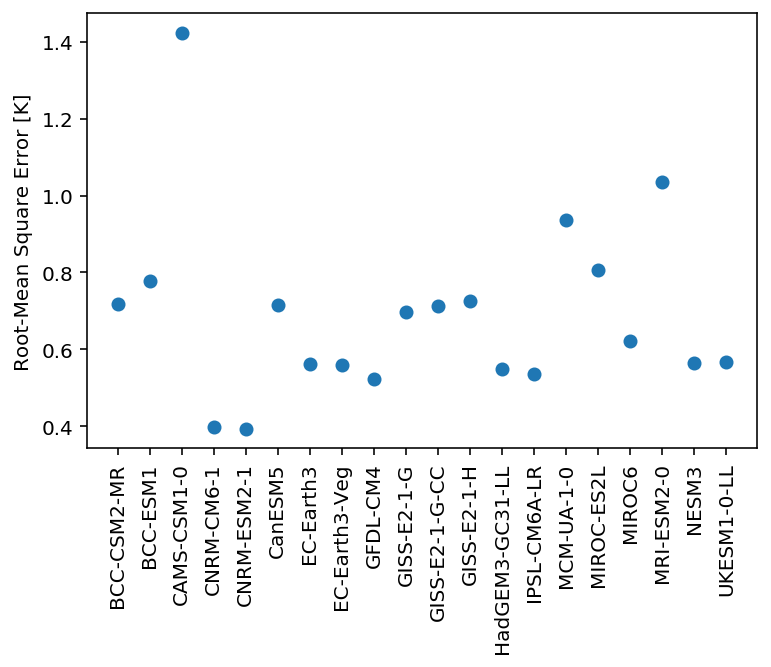

In [34]:
plt.plot(list(ens.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
#plt.ylim([0,4.25])

In [18]:
rmse_tas

array([1.63380416, 1.86142087, 1.69358948, 1.42370996, 2.10765918,
       1.97754579, 1.63110232, 1.79627861, 1.53376457, 1.4029837 ,
       2.27349437, 3.68173347, 2.85588393, 1.80691406, 1.87983856])

In [20]:
obs_tas

<xarray.DataArray 'tas' (lat: 178, lon: 360)>
array([[229.037241  , 229.0091518 , 228.98152539, ..., 229.13306704,
        229.09571863, 229.0653739 ],
       [229.67550478, 229.62681076, 229.579526  , ..., 229.86485526,
        229.78552742, 229.72661309],
       [229.96796695, 229.87670677, 229.79030623, ..., 230.30839943,
        230.1756355 , 230.06632205],
       ...,
       [255.93007811, 255.94938773, 255.96922626, ..., 255.87063647,
        255.89075487, 255.91059718],
       [255.73711553, 255.74961716, 255.76281145, ..., 255.70206449,
        255.71405876, 255.7254419 ],
       [255.59324216, 255.60004648, 255.60704613, ..., 255.57382484,
        255.58041799, 255.58676893]])
Coordinates:
  * lat      (lat) float64 -88.5 -87.5 -86.5 -85.5 -84.5 ... 85.5 86.5 87.5 88.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [34]:
rmse_tas

array([1.63380416, 1.86142087, 1.69358948, 1.42370996, 2.10765918,
       1.97754579, 1.63110232, 1.79627861, 1.53376457, 1.4029837 ,
       2.27349437, 3.68173347, 2.85588393, 1.80691406, 1.87983856])

In [23]:
obs_tas_rmse

array(0.)

In [35]:
get_rmse = np.array(list(ens.rmse.values()))
get_rmse

array([0.71826382, 0.77836905, 1.42263466, 0.39699426, 0.39367146,
       0.71458986, 0.56048595, 0.55899026, 0.52351084, 0.697479  ,
       0.71164574, 0.72596849, 0.54777494, 0.53696652, 0.93585172,
       0.80708051, 0.62087528, 1.03447686, 0.56380608, 0.56568862])

In [39]:
rmse_tas = np.array(list(ens_tas.rmse.values()))
rmse_pr = np.array(list(ens_pr.rmse.values()))
rmse_psl = np.array(list(ens_psl.rmse.values()))
rmse_uas = np.array(list(ens_uas.rmse.values()))
rmse_vas = np.array(list(ens_vas.rmse.values()))

In [40]:
rmse_tas_med = np.median(rmse_tas)
rmse_pr_med = np.median(rmse_pr)
rmse_psl_med = np.median(rmse_psl)
rmse_uas_med = np.median(rmse_uas)
rmse_vas_med = np.median(rmse_vas)

In [41]:
tas_rmse_to_plot = rmse_tas/rmse_tas_med
tas_rmse_to_plot

array([0.90419583, 1.03016569, 0.93728281, 0.78792345, 1.1664413 ,
       1.09443268, 0.90270055, 0.99411403, 0.84883095, 0.77645292,
       1.25821943, 2.03758085, 1.58053114, 1.        , 1.04035859])

In [42]:
pr_rmse_to_plot = rmse_pr/rmse_pr_med
psl_rmse_to_plot = rmse_psl/rmse_psl_med
uas_rmse_to_plot = rmse_uas/rmse_uas_med
vas_rmse_to_plot = rmse_vas/rmse_vas_med

In [43]:
test = [tas_rmse_to_plot, pr_rmse_to_plot, psl_rmse_to_plot, uas_rmse_to_plot, vas_rmse_to_plot]
test

[array([0.90419583, 1.03016569, 0.93728281, 0.78792345, 1.1664413 ,
        1.09443268, 0.90270055, 0.99411403, 0.84883095, 0.77645292,
        1.25821943, 2.03758085, 1.58053114, 1.        , 1.04035859]),
 array([0.96752221, 1.17302719, 0.89036177, 0.93685286, 1.        ,
        0.73152739, 0.78133653, 1.14851826, 1.20439875, 0.86406973,
        1.28851424, 1.17944821, 1.0981144 , 1.04592022, 0.89143966]),
 array([1.56354452, 0.50228665, 0.96611624, 0.90805042, 1.14057085,
        0.44214975, 1.08885264, 0.63473426, 1.24990467, 1.00977024,
        1.52353766, 1.79210597, 0.92431805, 0.73326185, 1.        ]),
 array([1.32884633, 2.69466086, 0.76875345, 0.75074872, 1.01921355,
        0.92729119, 0.75360502, 1.1312386 , 1.15934503, 0.82266335,
        0.77462063, 1.82532748, 1.        , 1.49022802, 0.86386122]),
 array([1.20861221, 2.29522335, 0.60128746, 0.59920348, 1.17176736,
        0.90134437, 0.79200692, 1.1840816 , 1.21860588, 0.83997682,
        0.80808546, 1.32339372, 1.      

In [44]:
a = np.array((1,2,3))
b = np.array((2,3,4))
np.hstack((a,b))


array([1, 2, 3, 2, 3, 4])

In [45]:
a = np.array([[1],[2],[3]])
b = np.array([[2],[3],[4]])
np.hstack((a,b))

array([[1, 2],
       [2, 3],
       [3, 4]])

In [68]:
a

array([[1],
       [2],
       [3]])

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}

In [46]:
rmse_array = np.vstack((tas_rmse_to_plot, pr_rmse_to_plot, psl_rmse_to_plot, uas_rmse_to_plot, vas_rmse_to_plot))

In [82]:
tas_rmse_to_plot

array([0.90419583, 1.03016569, 0.93728281, 0.78792345, 1.1664413 ,
       1.09443268, 0.90270055, 0.99411403, 0.84883095, 0.77645292,
       1.25821943, 2.03758085, 1.58053114, 1.        , 1.04035859])

In [83]:
rmse_array

array([[0.90419583, 1.03016569, 0.93728281, 0.78792345, 1.1664413 ,
        1.09443268, 0.90270055, 0.99411403, 0.84883095, 0.77645292,
        1.25821943, 2.03758085, 1.58053114, 1.        , 1.04035859],
       [0.96752221, 1.17302719, 0.89036177, 0.93685286, 1.        ,
        0.73152739, 0.78133653, 1.14851826, 1.20439875, 0.86406973,
        1.28851424, 1.17944821, 1.0981144 , 1.04592022, 0.89143966],
       [1.56354452, 0.50228665, 0.96611624, 0.90805042, 1.14057085,
        0.44214975, 1.08885264, 0.63473426, 1.24990467, 1.00977024,
        1.52353766, 1.79210597, 0.92431805, 0.73326185, 1.        ],
       [1.32884633, 2.69466086, 0.76875345, 0.75074872, 1.01921355,
        0.92729119, 0.75360502, 1.1312386 , 1.15934503, 0.82266335,
        0.77462063, 1.82532748, 1.        , 1.49022802, 0.86386122],
       [1.20861221, 2.29522335, 0.60128746, 0.59920348, 1.17176736,
        0.90134437, 0.79200692, 1.1840816 , 1.21860588, 0.83997682,
        0.80808546, 1.32339372, 1.        , 

In [74]:
# instead of stacking arrays lets put pandas to work
carpet_dict = {'tas': tas_rmse_to_plot, 'pr': pr_rmse_to_plot, 'psl': psl_rmse_to_plot, 'uas': uas_rmse_to_plot, 
             'vas': vas_rmse_to_plot}

In [77]:
carpet_df = pd.DataFrame(data=carpet_dict)
carpet_df.head()

tas        pr       psl       uas       vas
0  0.904196  0.967522  1.563545  1.328846  1.208612
1  1.030166  1.173027  0.502287  2.694661  2.295223
2  0.937283  0.890362  0.966116  0.768753  0.601287
3  0.787923  0.936853  0.908050  0.750749  0.599203
4  1.166441  1.000000  1.140571  1.019214  1.171767

In [80]:
carpet_df_transposed = carpet_df.T

In [83]:
carpet_df_transposed

0         1         2         3         4         5         6   \
tas  0.904196  1.030166  0.937283  0.787923  1.166441  1.094433  0.902701   
pr   0.967522  1.173027  0.890362  0.936853  1.000000  0.731527  0.781337   
psl  1.563545  0.502287  0.966116  0.908050  1.140571  0.442150  1.088853   
uas  1.328846  2.694661  0.768753  0.750749  1.019214  0.927291  0.753605   
vas  1.208612  2.295223  0.601287  0.599203  1.171767  0.901344  0.792007   

           7         8         9         10        11        12        13  \
tas  0.994114  0.848831  0.776453  1.258219  2.037581  1.580531  1.000000   
pr   1.148518  1.204399  0.864070  1.288514  1.179448  1.098114  1.045920   
psl  0.634734  1.249905  1.009770  1.523538  1.792106  0.924318  0.733262   
uas  1.131239  1.159345  0.822663  0.774621  1.825327  1.000000  1.490228   
vas  1.184082  1.218606  0.839977  0.808085  1.323394  1.000000  1.624644   

           14  
tas  1.040359  
pr   0.891440  
psl  1.000000  
uas  0.863861  
vas  0.864792

In [87]:
columnsNamesArr = carpet_df.columns.values

In [92]:
list(carpet_df.columns.values)

['tas', 'pr', 'psl', 'uas', 'vas']

In [91]:
columnsNamesArr

array(['tas', 'pr', 'psl', 'uas', 'vas'], dtype=object)

In [84]:
rmse_array.shape

(5, 15)

In [97]:
np.arange(1,(carpet_df.shape[1])+1) - 0.5

array([0.5, 1.5, 2.5, 3.5, 4.5])

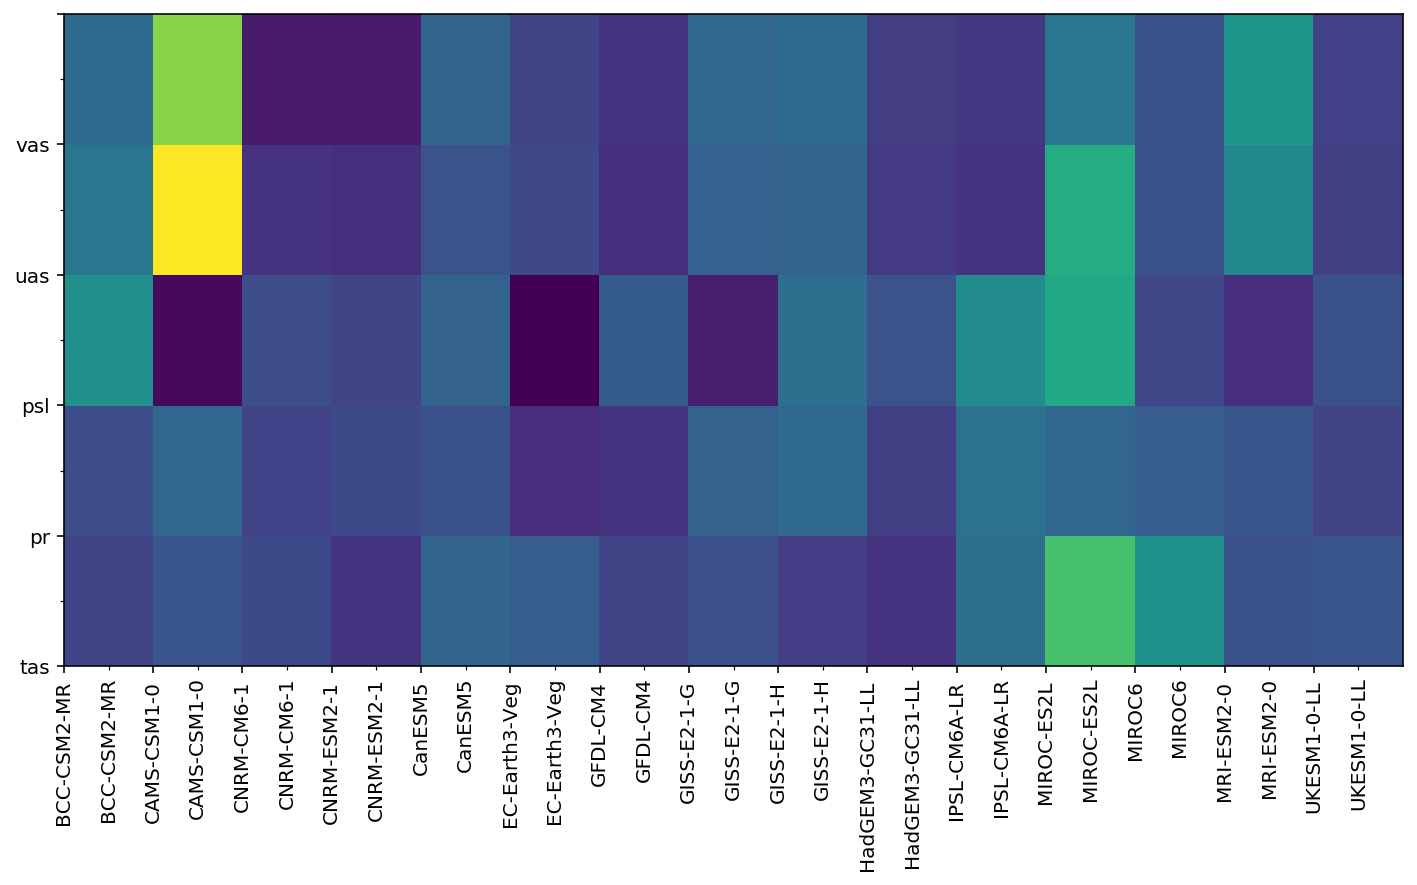

In [100]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()

c = ax.pcolor(carpet_df_transposed)
ax.set_title('')
plt.xticks(np.arange(len(ens_tas.attrs['rmse'].keys())),list(ens_tas.attrs['rmse'].keys()),rotation=90);
#plt.yticks(['tas', 'pr', 'psl', 'uas', 'vas']);
#plt.tick.label1.set_horizontalalignment('center')
# Hide major tick labels


# Customize minor tick labels
#ax.set_xticks([1.5,2.5,3.5,4.5,5.5],      minor=True)
ax.set_xticks(np.arange(1,(rmse_array.shape[1])+1) - 0.5, minor = True);
ax.set_yticks(np.arange(1,(carpet_df.shape[1])+1) - 0.5, minor = True);
ax.set_xticklabels(list(ens_tas.attrs['rmse'].keys()), rotation = 90, minor = True);
ax.set_yticklabels(list(carpet_df.columns.values));

In [107]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()

c = ax.pcolor(carpet_df_transposed)
ax.set_title('')
plt.xticks(np.arange(len(ens_tas.attrs['rmse'].keys())),list(ens_tas.attrs['rmse'].keys()),rotation=90);
#plt.yticks(['tas', 'pr', 'psl', 'uas', 'vas']);
#plt.tick.label1.set_horizontalalignment('center')
# Hide major tick labels
ax.set_xticklabels(['']);
ax.set_yticklabels(['']);

# Customize minor tick labels
#ax.set_xticks([1.5,2.5,3.5,4.5,5.5],      minor=True)
ax.set_xticks(np.arange(1,(rmse_array.shape[1])+1) - 0.5, minor = True);
ax.set_yticks(np.arange(1,(carpet_df.shape[1])+1) - 0.5, minor = True);
ax.set_xticklabels(list(ens_tas.attrs['rmse'].keys()), rotation = 90, minor = True);
ax.set_yticklabels(list(carpet_df.columns.values), minor = True);

fig.colorbar(c, ax = ax)

In [81]:
fig, ax = plt.subplots()

c = ax.pcolor(carpet_df_transposed)
ax.set_title('')
plt.xticks(np.arange(len(ens_tas.attrs['rmse'].keys())),list(ens_tas.attrs['rmse'].keys()),rotation=90);

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5')]

In [57]:
np.arange(0,(rmse_array.shape[1]))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [63]:
np.arange(1,(rmse_array.shape[1])+1) - 0.5

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5])

In [65]:
list(np.arange(1,(rmse_array.shape[1])+1) - 0.5)

[0.5,
 1.5,
 2.5,
 3.5,
 4.5,
 5.5,
 6.5,
 7.5,
 8.5,
 9.5,
 10.5,
 11.5,
 12.5,
 13.5,
 14.5]

In [64]:
[1.5,2.5,3.5,4.5,5.5]

[1.5, 2.5, 3.5, 4.5, 5.5]

In [36]:
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# load some financial data; apple's stock price
with cbook.get_sample_data('aapl.npz') as fh:
    r = np.load(fh)['price_data'].view(np.recarray)
r = r[-250:]  # get the last 250 days
# Matplotlib works better with datetime.datetime than np.datetime64, but the
# latter is more portable.
date = r.date.astype('O')

fig, ax = plt.subplots()
ax.plot(date, r.adj_close)

ax.xaxis.set_major_locator(dates.MonthLocator())
# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(r) // 2
ax.set_xlabel(str(date[imid].year))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/mpl-data/sample_data/aapl.npz'

Text(0.5, 1.0, 'tas')

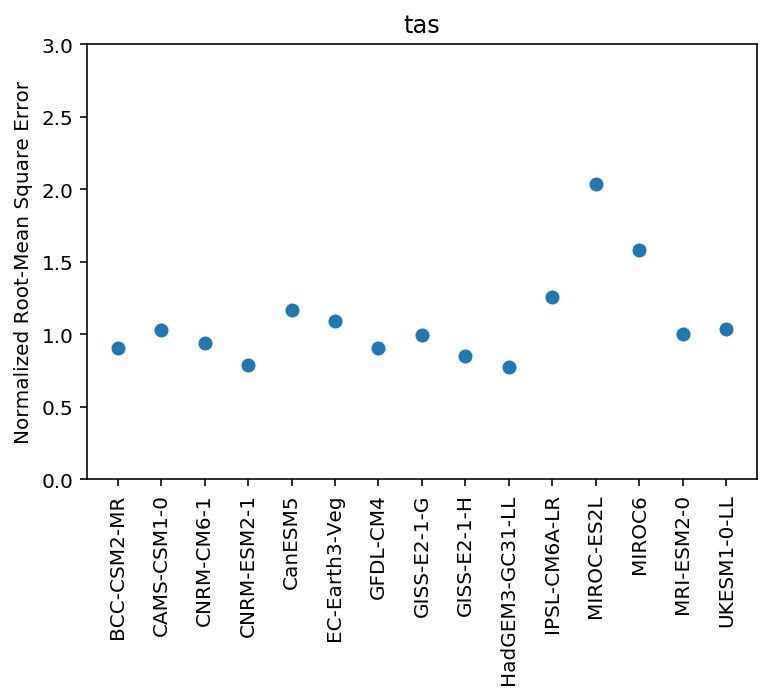

In [37]:
plt.plot((list(ens_tas.attrs['rmse'].values()))/rmse_tas_med,'C0o')
plt.xticks(np.arange(len(ens_tas.attrs['rmse'].keys())),list(ens_tas.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
plt.ylim([0,3.0])
plt.title('tas')

In [38]:
plt.plot((list(ens_pr.attrs['rmse'].values()))/rmse_pr_med,'C0o')
plt.xticks(np.arange(len(ens_pr.attrs['rmse'].keys())),list(ens_pr.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
plt.ylim([0,3.0])
plt.title('pr')

Text(0.5, 1.0, 'pr')

Text(0.5, 1.0, 'psl')

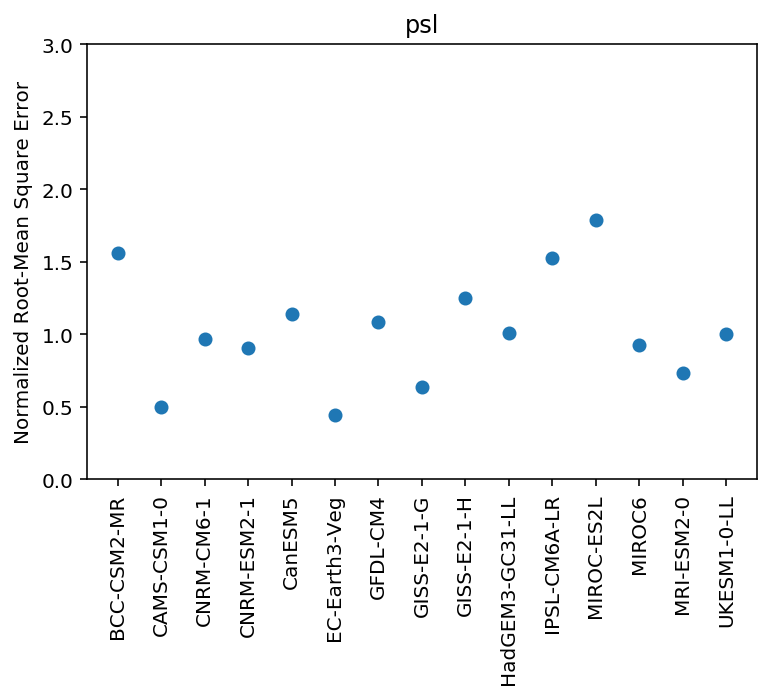

In [39]:
plt.plot((list(ens_psl.attrs['rmse'].values()))/rmse_psl_med,'C0o')
plt.xticks(np.arange(len(ens_psl.attrs['rmse'].keys())),list(ens_psl.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
plt.ylim([0,3.0])
plt.title('psl')

Text(0.5, 1.0, 'uas')

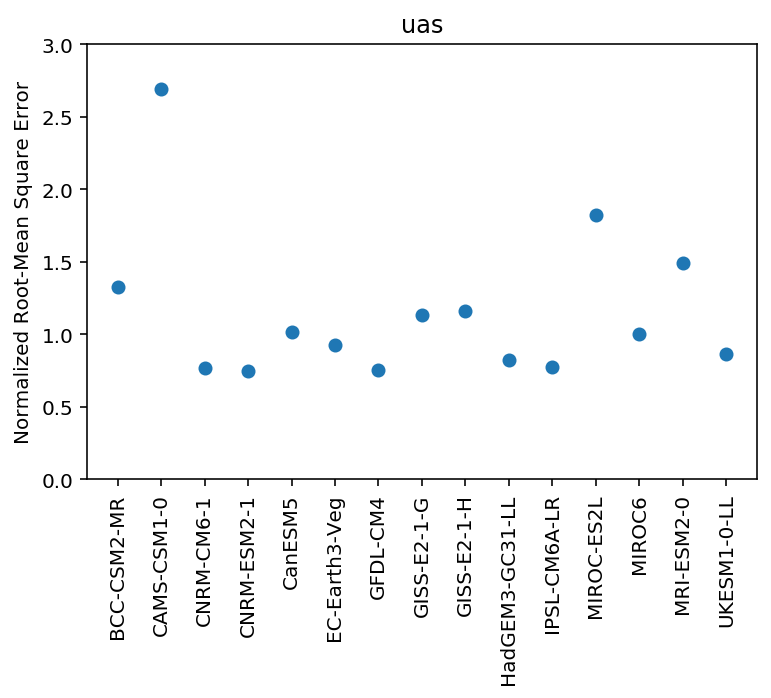

In [41]:
plt.plot((list(ens_uas.attrs['rmse'].values()))/rmse_uas_med,'C0o')
plt.xticks(np.arange(len(ens_uas.attrs['rmse'].keys())),list(ens_uas.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
plt.ylim([0,3.0])
plt.title('uas')

Text(0.5, 1.0, 'vas')

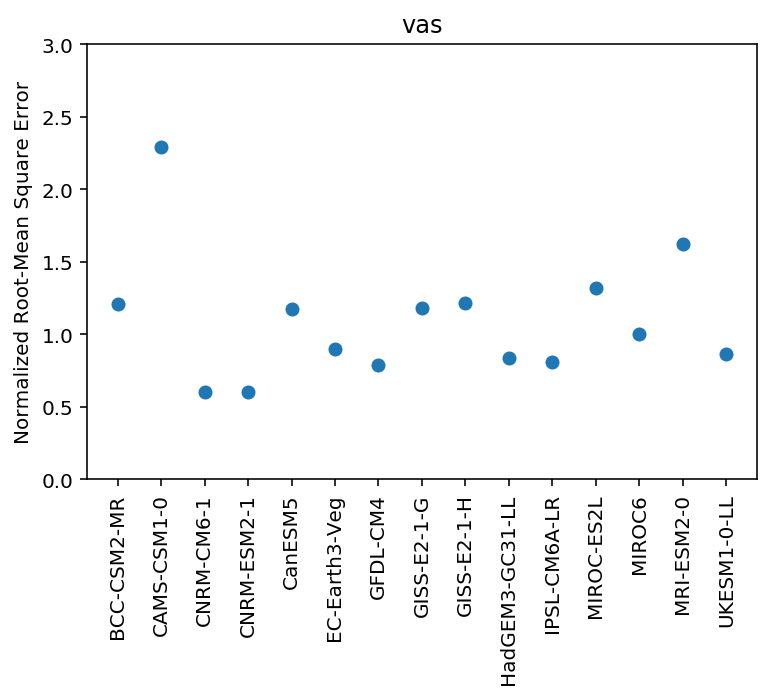

In [42]:
plt.plot((list(ens_vas.attrs['rmse'].values()))/rmse_vas_med,'C0o')
plt.xticks(np.arange(len(ens_vas.attrs['rmse'].keys())),list(ens_vas.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
plt.ylim([0,3.0])
plt.title('vas')